In [134]:
import pandas as pd
import numpy as np
from significance_of_mean_cuda import significance_of_mean_cuda
import time
from utils import MW, ttests, qvalues
import sklearn
import seaborn as sns

In [2]:
%load_ext cython
%load_ext rpy2.ipython

/home/ekvall/anaconda3/envs/my-r-env/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:14: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex
/home/ekvall/anaconda3/envs/my-r-env/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:34: UserWarning: pandas >= 1.0 is not supported.
  warnings.warn('pandas >= 1.0 is not supported.')


In [3]:
%%R

require(ggplot2)
install.packages("devtools")
library("devtools")
install_github("bdsegal/fastPerm")

library(fastPerm)

R[write to console]: Loading required package: ggplot2

R[write to console]: Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

R[write to console]: trying URL 'https://cloud.r-project.org/src/contrib/devtools_2.2.2.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 375464 bytes (366 KB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to cons

In [4]:
!ls "./data/nature18003-s2/"

CPTAC_BC_SupplementaryTable01.xlsx  CPTAC_BC_SupplementaryTable03.xlsx


In [5]:
path = "./data/nature18003-s2/"

In [6]:
T1 = pd.read_excel(path + "CPTAC_BC_SupplementaryTable01.xlsx")
T3 = pd.read_excel(path + "CPTAC_BC_SupplementaryTable03.xlsx")

## Extract important column headings

In [7]:
paiteint_id = T1.columns[0]
stats_col = T1.columns[5: 5 + 3]

### Patient column  

In [8]:
paiteint_id

'Sample ID'

### Cancer phenotype coulmns

In [9]:
stats_col

Index(['ER Status', 'PR Status', 'HER2 Status'], dtype='object')

### Check viable phenotype status

In [10]:
all_lab = list()
for r in T1[stats_col].iterrows():
    all_lab += list(r[1].values)

In [11]:
list(set(all_lab))

['Negative', 'Equivocal', 'Positive', 'Indeterminate']

### Let's drop patient with "Equivocal" and "Indeterminate" status

In [12]:
drop_label = ['Indeterminate', 'Equivocal']

In [13]:
T1.head()

,Sample ID,TCGA ID,Biospecimen Barcode Side,UIUD,PAM50,ER Status,PR Status,HER2 Status,QC Status,Proteome Cluster (see Fig. 3b),...,iTRAQReporterIon,CommonControl,GATA3 Mutation,PIK3CA Mutation,TP53 Mutation,PIK3CA missense mutation in helical domain all tumors,PIK3CA missense mutation in kinase domain all tumors,TP53 Nonsense/Frameshift all tumors,TP53 Missense mutation all tumors,TP53 missense mutations in DNA binding domain all tumors
0,A2-A0CM,TCGA-A2-A0CM,TCGA-A2-A0CM-01A-11-A21V-30,330F7598-824C-4CD6-9303-A27FE74A6695,Basal,Negative,Negative,Negative,pass,1.0,...,116,YES,NaN,NaN,Frame_Shift_Del|Somatic|p.E204fs,0.0,0.0,1.0,NaN,NaN
1,A2-A0D2,TCGA-A2-A0D2,TCGA-A2-A0D2-01A-12-A21W-30,308CCD79-C164-4397-92BC-A1CD243C8E7D,Basal,Negative,Negative,Negative,pass,1.0,...,114,NO,NaN,NaN,Frame_Shift_Del|Somatic|p.P318fs,0.0,0.0,1.0,NaN,NaN
2,A2-A0EQ,TCGA-A2-A0EQ,TCGA-A2-A0EQ-01A-41-A21W-30,04217F65-2907-478B-B0C5-EB65370198DA,Her2,Negative,Negative,Positive,pass,1.0,...,116,NO,NaN,Missense_Mutation|Somatic|p.H1047R,In_Frame_Del|Somatic|p.IY162in_frame_delN,NaN,1.0,NaN,NaN,NaN
3,A2-A0EV,TCGA-A2-A0EV,TCGA-A2-A0EV-01A-41-A21V-30,38F98E5F-7FA4-4C89-8D81-516CF865BEEB,LumA,Positive,Positive,Negative,pass,3.0,...,114,NO,NaN,In_Frame_Ins|Somatic|p.E469in_frame_insDK,NaN,NaN,NaN,0.0,0.0,0.0
4,A2-A0EX,TCGA-A2-A0EX,TCGA-A2-A0EX-01A-41-A21V-30,78271500-147B-40C5-B789-0CF0C7CDBCE2,LumA,Positive,Positive,Negative,pass,3.0,...,116,NO,NaN,Missense_Mutation|Somatic|p.E545K,NaN,1.0,NaN,0.0,0.0,0.0


In [14]:
mask1 = [True if (len(set(r[1].values) & set(drop_label)) == 0) else False for r in T1[stats_col].iterrows()]
T1 = T1[mask1]
T1.reset_index(drop=True, inplace=True)

### Let's divide the dataframe into two dataframes with triple negative (TN) and non-triple negative (NTN)

In [15]:
mask2 = [all([True if v=='Negative' else False for v in r[1].values] ) for r in T1[stats_col].iterrows()]

T1_TNP = T1[np.array(mask2)]
T1_TNP.reset_index(drop=True, inplace=True)

T1_not_TNP = T1[~np.array(mask2)]
T1_not_TNP.reset_index(drop=True, inplace=True)



### Obtain patient ids for NT and NTN

In [16]:
TNPpateintIds = T1_TNP[paiteint_id].values
NotTNPpateintIds = T1_not_TNP[paiteint_id].values

### Remove genes (rows) containing NaN for both TN and NTN i.e., make sure all patients have same the gene when comparing.

In [17]:
def getpatientId(ids):
    patitentList = list()
    for i in ids:
        p_id = T3[T3.columns[[i in c for c in T3.columns]]].columns
        patitentList += list(p_id)
    return patitentList

In [18]:
only_patientDf = T3[getpatientId(NotTNPpateintIds) + getpatientId(TNPpateintIds)]

In [19]:
only_patientDf.dropna(inplace=True)

/home/ekvall/anaconda3/envs/my-r-env/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [20]:
NotTNP_df =  only_patientDf[getpatientId(NotTNPpateintIds)]
TNP_df =  only_patientDf[getpatientId(TNPpateintIds)]

In [21]:
NotTNP_Arr, TNP_Arr =NotTNP_df.values, TNP_df.values

In [22]:
NotTNP_Arr.shape

(8051, 80)

In [23]:
TNP_Arr.shape

(8051, 26)

### There are 80 patients without triple negative (NTN) and 26 patients with triple negtive (TN), and with a total of 8051 quantified genes.

# Experiment time

## Let's start with a rather small binsize=6.

In [170]:
start = time.time()

SGM = significance_of_mean_cuda(6, dtype_v=np.uint32,dtype_A=np.float64)
SGM.run(TNP_Arr, NotTNP_Arr)
P_e_list = list(1 - SGM.p_values)

end = time.time()
print(end - start)

1.982856035232544


In [27]:
x = pd.DataFrame(TNP_Arr, columns=list(range(TNP_Arr.shape[1]))).T
y = pd.DataFrame(NotTNP_Arr, columns=list(range(NotTNP_Arr.shape[1]))).T
n_samples = x.shape[1]
outputDf = pd.DataFrame(n_samples * [0], columns=["output"]).T

In [196]:
%R -i x
%R -i y
%R -i outputDf
%R -i n_samples

In [197]:
%%R
runFastPerm <- function(x,y,output, n_samples) {
    e <- list(mode="vector",length=n_samples)
        for (i in 1:n_samples) {
      
            mStopDiffMean(x[[i]], y[[i]])
            valX = fastPerm(x[[i]], y[[i]], testStat = diffMean)
            
            print(valX)
            valX <-unlist(valX)

      
            output[[i]] <- as.numeric(valX[1])
      
            }
    

    return(output)


}


In [198]:
start = time.time()
%R out <- runFastPerm(x,y, outputDf, 10)
end = time.time()
print(end - start)

    fastPerm Two Sample Test   

difference of means
1,000 iterations within partitions

observed statistic = 0.0769
p-value = 0.797
mStop = 20, deviance = 193, AIC = 375
    fastPerm Two Sample Test   

difference of means
1,000 iterations within partitions

observed statistic = 0.0734
p-value = 0.811
mStop = 20, deviance = 231, AIC = 413
    fastPerm Two Sample Test   

difference of means
1,000 iterations within partitions

observed statistic = 0.0706
p-value = 0.81
mStop = 20, deviance = 171, AIC = 352
    fastPerm Two Sample Test   

difference of means
1,000 iterations within partitions

observed statistic = 0.076
p-value = 0.798
mStop = 20, deviance = 185, AIC = 367
    fastPerm Two Sample Test   

difference of means
1,000 iterations within partitions

observed statistic = 0.0742
p-value = 0.812
mStop = 20, deviance = 208, AIC = 390
    fastPerm Two Sample Test   

difference of means
1,000 iterations within partitions

observed statistic = 0.073
p-value = 0.804
mStop = 20, dev

In [171]:
2738 / 60

45.63333333333333

In [31]:
%R -o out

In [33]:
outT = out.T

In [39]:
P_fp_list =list(outT.values.ravel())

### Parallelized exact test takes ~3s

In [41]:
start = time.time()

P_mw_list = MW(TNP_Arr, NotTNP_Arr)

end = time.time()
print(end - start)

1.4578099250793457


### Mann-Whitney exact test takes ~1s

In [143]:
start = time.time()

P_t_list = ttests(TNP_Arr, NotTNP_Arr)

end = time.time()
print(end - start)

1.3899211883544922


In [184]:
df_mw

,p,q
6813,4.888208e-13,3.342369e-09
6814,3.764270e-12,1.286932e-08
2323,3.099803e-11,6.768449e-08
2322,3.959537e-11,6.768449e-08
1369,3.377987e-10,4.424156e-07
...,...,...
3754,1.000000e+00,8.492878e-01
4768,1.000000e+00,8.492878e-01
1940,1.000000e+00,8.492878e-01
584,1.000000e+00,8.492878e-01


In [177]:
df_e = pd.DataFrame({"p":P_e_list})
df_mw = pd.DataFrame({"p":P_mw_list})
df_tt = pd.DataFrame({"p":P_t_list})
df_fp = pd.DataFrame({"p":list(np.array(P_fp_list) / 2)})

In [178]:
df_e = qvalues(df_e, pi0=None)
df_mw = qvalues(df_mw, pi0=None)
df_tt = qvalues(df_tt, pi0=None)
df_fp = qvalues(df_fp, pi0=None)

In [179]:
df_e["q"][df_e["q"]<0.01].shape


(394,)

In [180]:
df_mw["q"][df_mw["q"]<0.01].shape

(421,)

In [181]:
df_tt["q"][df_tt["q"]<0.01].shape

(351,)

In [182]:
df_fp["q"][df_fp["q"]<0.01].shape

(8051,)

In [183]:
data_e = df_e["q"][df_e["q"]<0.1]
data_mw = df_mw["q"][df_mw["q"]<0.1]
data_tt = df_tt["q"][df_tt["q"]<0.1]
data_fp = df_fp["q"][df_fp["q"]<0.1]


In [160]:
def preparePandas(q_values, cumulative, test="parallelized shift"):
    preparePd = list()
    for q, cum in zip(q_values, cumulative):
        preparePd.append([q, cum, test])
    return preparePd

In [161]:

values, base = np.histogram(data_e, bins=40)
cumulative = np.cumsum(values)
exactData = preparePandas(base[:-1], cumulative)

values, base = np.histogram(data_mw, bins=40)
cumulative = np.cumsum(values)
mwuData = preparePandas(base[:-1], cumulative, "MWU")

values, base = np.histogram(data_tt, bins=40)
cumulative = np.cumsum(values)
ttData = preparePandas(base[:-1], cumulative, "t test")

values, base = np.histogram(data_fp, bins=40)
cumulative = np.cumsum(values)
fpData = preparePandas(base[:-1], cumulative, "fastPerm")

In [164]:
D = exactData +  mwuData + ttData + fpData

In [165]:
pdData = pd.DataFrame(D, columns=['%','n', 'Method'])

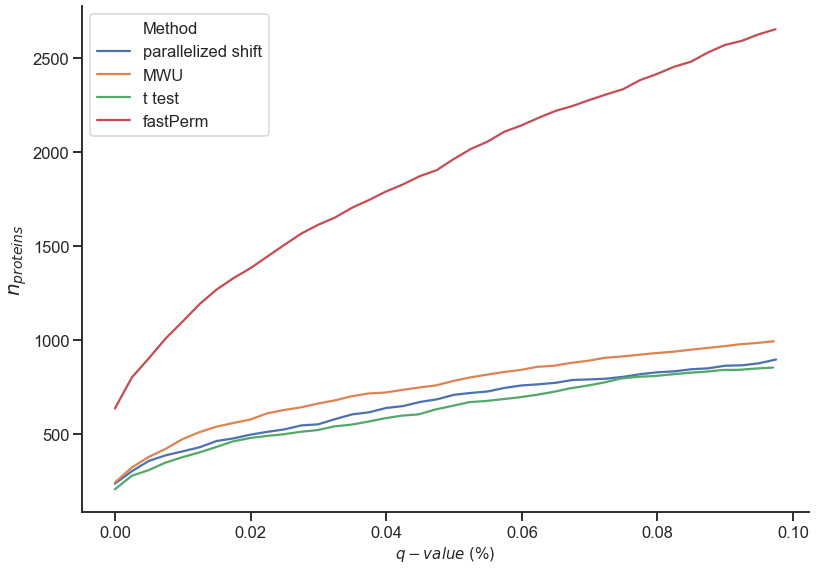

In [167]:
a4_dims = (11.7, 8.27)

fig, ax = plt.subplots(figsize=a4_dims)

sns.set(style="white")
sns.set_context("talk")

snsPlot = sns.lineplot(x="%", y="n",
             hue="Method",
             data=pdData, ax=ax)

plt.ylabel(r"$n_{proteins}$",fontsize=20)
        
        
plt.xlabel(r"$q-value\ (\%)$",fontsize=15)

sns.set_style("ticks")
sns.despine()
plt.tight_layout()
plt.savefig("figures/experiment/n_proteins")


In [169]:
!ls "figures/experiment/"

n_proteins.png


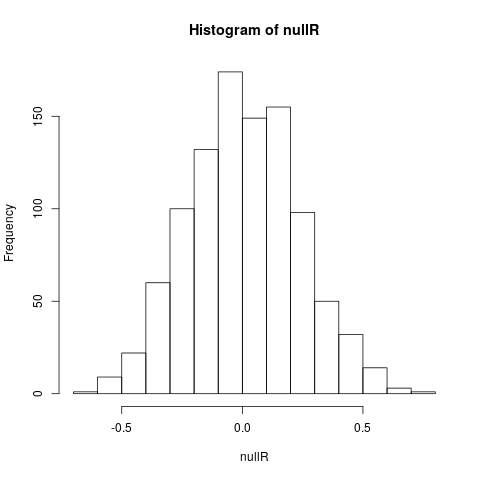

In [195]:
%%R
# dummy data
set.seed(1)
x <- runif(20)
y <- 0.5 * x
y <- y + rnorm(20)

## set up for the permutation, compute observed R
nullR <- numeric(length = 1000)
nullR[1] <- cor(x, y) ## obsered R in [1]
N <- length(x)


## permutation test
for(i in seq_len(999) + 1) {
    nullR[i] <- cor(x[sample(N)], y)
}

hist(nullR)

In [188]:


x

,0,1,2,3,4,5,6,7,8,9,...,8041,8042,8043,8044,8045,8046,8047,8048,8049,8050
0,0.683404,0.694424,0.698098,0.687077,0.687077,0.698098,0.698098,0.698098,-2.652150,-0.984373,...,-0.187220,0.617280,-1.502339,2.130769,1.098511,-0.819065,-0.675798,0.014823,1.550354,-0.216608
1,0.107491,0.104164,0.107491,0.097512,0.104164,0.104164,0.104164,0.104164,-0.880454,-1.512473,...,-0.541160,2.136604,2.322883,1.225166,1.777351,1.062172,-2.759878,0.154061,0.237221,0.270485
2,-0.398560,-0.392601,-0.392601,-0.392601,-0.395581,-0.392601,-0.392601,-0.392601,-2.504862,0.694810,...,-0.663710,-0.273433,-1.631953,0.536912,4.978915,4.323489,-4.792895,-0.294287,0.724603,-1.745163
3,0.655850,0.658143,0.655850,0.655850,0.651264,0.658143,0.655850,0.655850,-1.969534,1.307036,...,0.039057,1.394167,-0.974410,2.588774,1.680781,3.145951,-2.462510,-0.109983,1.894022,1.135068
4,-1.123173,-1.123173,-1.116861,-1.129486,-1.129486,-1.120017,-1.123173,-1.123173,2.244584,-2.575065,...,0.499158,2.585463,0.259280,0.764286,0.041497,-0.113161,-0.583448,-0.233100,0.729567,1.045196
5,0.323663,0.326973,0.326973,0.330283,0.326973,0.326973,0.326973,0.326973,1.932290,-1.910542,...,-1.996601,-2.069419,-3.472831,-3.724386,-2.542740,0.356762,1.399391,-2.092589,-2.185267,0.621557
6,2.455138,2.480137,2.480137,2.461956,2.477864,2.471046,2.480137,2.480137,3.959607,-1.858279,...,3.311912,3.277823,-0.940144,1.566547,-2.724144,1.768809,-0.056098,0.523418,0.180254,-0.481076
7,0.831132,0.856540,0.856540,0.836778,0.865009,0.856540,0.850894,0.850894,-0.967196,2.838370,...,-1.720969,0.317324,5.480811,1.686537,0.574228,0.263685,-4.690892,0.051950,2.694391,-0.475973
8,-0.106680,-0.106680,-0.106680,-0.106680,-0.106680,-0.106680,-0.106680,-0.106680,0.025189,-1.177327,...,0.916871,1.224565,-1.130231,2.044034,1.431787,-2.059591,-3.620036,1.494581,-0.269946,-0.605897
9,-1.947792,-1.952718,-1.955180,-1.947792,-1.957643,-1.955180,-1.955180,-1.955180,-1.004611,-2.551133,...,-0.696784,-1.248410,-0.662307,-1.896077,-2.989479,-0.645069,0.539449,-0.709097,-1.918241,-1.312438
